In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os.path
import datetime
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.modelbuilder.supervised  import SupervisedDataLoader 
from datatools.customtransformers import LogTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV 
import warnings
warnings.filterwarnings('ignore')
% matplotlib inline 
np.set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.4f}'.format
sns.set()
import logging
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')
logger.setLevel(logging.DEBUG)


06-Jan-19 18:22:11 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown
06-Jan-19 18:22:11 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


In [3]:
# few imports
from mltools.mlhelper import missing_values

#helper functions
def get_nullframe(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    return pd.DataFrame({'feature':null_sum.index,'count':null_sum.values,
                          'null_percent':(null_sum.values/dataset.shape[0])*100}).sort_values(by=['count'],ascending=False)

In [4]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [5]:
load_app_config()
DIRECTORY="AVLoanPrediction"
TRAIN_FILE  = "train.csv"
TEST_FILE  = "test.csv"
RESPONSE = "Loan_Status"
input_path = get_datafolder_path()
train_file = os.path.join(input_path, DIRECTORY, TRAIN_FILE)
test_file = os.path.join(input_path, DIRECTORY, TEST_FILE)
supervisedloader = SupervisedDataLoader(train_file=train_file,test_file=test_file,response =RESPONSE) 
train_dataset,test_dataset = supervisedloader.load()
supervisedloader.response

06-Jan-19 18:22:11 - INFO - Adding D:\DataSource to system path
06-Jan-19 18:22:11 - INFO - Adding D:\MachineLearning to system path
06-Jan-19 18:22:11 - INFO - Loading train_file :D:\DataSource\AVLoanPrediction\train.csv
06-Jan-19 18:22:11 - INFO - Loading test_file :D:\DataSource\AVLoanPrediction\test.csv


'Loan_Status'

### Exploratory Data Analysis- EDA
###### Check frequency of response
###### Check if any rows have all columns reported missing
###### Check frequency of null values

In [6]:
display(train_dataset[supervisedloader.response].value_counts(normalize=True))

Y   0.6873
N   0.3127
Name: Loan_Status, dtype: float64

In [7]:
training_missing_values = missing_values(train_dataset)
all_missing  = training_missing_values[training_missing_values['Missing_Values'] ==train_dataset.shape[0]]
print("No of columns that have 100% missing values :{0}".format(all_missing.shape[0]))
null_count_train ,null_count_test =get_nullframe(train_dataset),get_nullframe(test_dataset)
display(pd.merge(null_count_train,null_count_test, suffixes=['_train','_test'], on=['feature'],how='outer'))

No of columns that have 100% missing values :0


,feature,count_train,null_percent_train,count_test,null_percent_test
0,Credit_History,50,8.1433,29.0000,7.9019
1,Self_Employed,32,5.2117,23.0000,6.2670
2,LoanAmount,22,3.5831,5.0000,1.3624
3,Dependents,15,2.4430,10.0000,2.7248
4,Loan_Amount_Term,14,2.2801,6.0000,1.6349
5,Gender,13,2.1173,11.0000,2.9973
6,Married,3,0.4886,nan,nan


In [8]:
display(train_dataset.describe())
display(train_dataset.info())

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.0000,614.0000,592.0000,600.0000,564.0000
mean,"5,403.4593","1,621.2458",146.4122,342.0000,0.8422
std,"6,109.0417","2,926.2484",85.5873,65.1204,0.3649
min,150.0000,0.0000,9.0000,12.0000,0.0000
25%,"2,877.5000",0.0000,100.0000,360.0000,1.0000
50%,"3,812.5000","1,188.5000",128.0000,360.0000,1.0000
75%,"5,795.0000","2,297.2500",168.0000,360.0000,1.0000
max,"81,000.0000","41,667.0000",700.0000,480.0000,1.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


None

In [9]:
continuous_columns = train_dataset.select_dtypes(np.number).columns.values.tolist()
categorical_columns = train_dataset.select_dtypes("object").columns.values.tolist()
categorical_columns.remove('Loan_ID')
continuous_columns.remove('Loan_Amount_Term')
continuous_columns.remove('Credit_History')
categorical_columns.append('Loan_Amount_Term')
categorical_columns.append('Credit_History')
display(",".join(continuous_columns))
display(",".join(categorical_columns))

'ApplicantIncome,CoapplicantIncome,LoanAmount'

'Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status,Loan_Amount_Term,Credit_History'

In [10]:
train_dataset['Credit_History'].fillna(train_dataset['Credit_History'].mode()[0], inplace=True)
test_dataset['Credit_History'].fillna(test_dataset['Credit_History'].mode()[0], inplace=True)
train_dataset['Self_Employed'].fillna(train_dataset['Self_Employed'].mode()[0], inplace=True)
test_dataset['Self_Employed'].fillna(test_dataset['Self_Employed'].mode()[0], inplace=True)

train_dataset['Dependents'].fillna(train_dataset['Dependents'].mode()[0],inplace=True)
test_dataset['Dependents'].fillna(test_dataset['Dependents'].mode()[0],inplace=True)

train_dataset['Loan_Amount_Term'].fillna(train_dataset['Loan_Amount_Term'].median(),inplace=True) 
test_dataset['Loan_Amount_Term'].fillna(test_dataset['Loan_Amount_Term'].median(),inplace=True)

train_dataset['Gender'].fillna(train_dataset['Gender'].mode()[0], inplace=True)
test_dataset['Gender'].fillna(test_dataset['Gender'].mode()[0], inplace=True)

train_dataset['Married'].fillna(train_dataset['Gender'].mode()[0], inplace=True)
test_dataset['Married'].fillna(test_dataset['Gender'].mode()[0], inplace=True)
train_dataset['Loan_Status'].replace('N', 0,inplace=True)
train_dataset['Loan_Status'].replace('Y', 1,inplace=True)
full_dataset =pd.concat(objs=[train_dataset, test_dataset], axis=0,sort =True).reset_index(drop=True) 
table = full_dataset.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)

def fage(x):
     return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
full_dataset['LoanAmount'].fillna(full_dataset[full_dataset['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [11]:
def emi_calculator(row): 
    r = 5.8/ (12 * 100) # one month interest 
    return (row['LoanAmount']* r * pow(1 + r, row['Loan_Amount_Term'])) / (pow(1 + r, row['Loan_Amount_Term']) - 1) 

In [12]:
def family_size(row):
    return row['Dependents'] + 2 if row['HasCoApplicant'] == 'N' else row['Dependents'] + 1

In [13]:
property_map = {'Rural':3,'Urban':1,'Semiurban':2}
full_dataset['TotalIncome'] =  full_dataset['ApplicantIncome']+ full_dataset['CoapplicantIncome']
full_dataset['HasCoApplicant'] = full_dataset['CoapplicantIncome'].apply(lambda x: "Y" if x > 0 else "N")
full_dataset['Married'] = (full_dataset['Married']=='Yes') * 1
full_dataset['Gender'] = (full_dataset['Gender']=='Male') * 1
full_dataset['Property_Area'] = full_dataset['Property_Area'].map(property_map)
full_dataset['LoanAmount']= full_dataset['LoanAmount']*1000
full_dataset['Dependents'].replace(('0', '1', '2', '3+'), (0, 1, 2, 3),inplace=True)
full_dataset['Dependents']  =full_dataset.apply(family_size ,axis=1)
full_dataset['EMI'] = full_dataset.apply(emi_calculator,axis=1)
full_dataset['Balance_TotalIncome']= full_dataset['TotalIncome']-full_dataset['EMI']
full_dataset['Balance_ApplicantIncome']= full_dataset['ApplicantIncome']-full_dataset['EMI']  
full_dataset['ApplicantIncomeRatio'] = full_dataset['ApplicantIncome']/ full_dataset['LoanAmount']
full_dataset['TotalIncomeRatio'] = full_dataset['TotalIncome']/ full_dataset['LoanAmount']

In [14]:
full_dataset_null =get_nullframe(full_dataset)
full_dataset_null

,feature,count,null_percent
0,Loan_Status,367,37.4108


In [15]:
full_dataset[(full_dataset['Loan_Status'] ==0)&(full_dataset['Credit_History']==1)].head()

,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,TotalIncome,HasCoApplicant,EMI,Balance_TotalIncome,Balance_ApplicantIncome,ApplicantIncomeRatio,TotalIncomeRatio
1,4583,"1,508.0000",1.0000,2,Graduate,1,"128,000.0000",360.0000,LP001003,0.0000,1,3,No,"6,091.0000",Y,751.0439,"5,339.9561","3,831.9561",0.0358,0.0476
9,12841,"10,968.0000",1.0000,2,Graduate,1,"349,000.0000",360.0000,LP001020,0.0000,1,2,No,"23,809.0000",Y,"2,047.7681","21,761.2319","10,793.2319",0.0368,0.0682
13,1853,"2,840.0000",1.0000,1,Graduate,1,"114,000.0000",360.0000,LP001029,0.0000,0,3,No,"4,693.0000",Y,668.8985,"4,024.1015","1,184.1015",0.0163,0.0412
18,4887,0.0000,1.0000,2,Not Graduate,1,"133,000.0000",360.0000,LP001038,0.0000,1,3,No,"4,887.0000",N,780.3815,"4,106.6185","4,106.6185",0.0367,0.0367
24,3717,"2,925.0000",1.0000,2,Graduate,1,"151,000.0000",360.0000,LP001052,0.0000,1,2,No,"6,642.0000",Y,885.9971,"5,756.0029","2,831.0029",0.0246,0.0440


In [16]:
full_dataset[(full_dataset['Loan_Status'] ==1)&(full_dataset['Credit_History']==1)]['TotalIncomeRatio'].mean()

0.0518011692938427

In [17]:
full_dataset[(full_dataset['Loan_Status'] ==1)&(full_dataset['Credit_History']==0)]['TotalIncomeRatio'].mean()

0.05005537889337303

In [18]:
full_dataset[(full_dataset['Loan_Status'] ==0)&(full_dataset['Credit_History']==1)]['TotalIncomeRatio'].mean()

0.052720359025753026

In [19]:
full_dataset[(full_dataset['Loan_Status'] ==0)&(full_dataset['Credit_History']==0)]['TotalIncomeRatio'].mean()

0.04603725861043875

In [20]:
train_Id  = full_dataset[full_dataset['Loan_Status'].notnull()]["Loan_ID"]
test_Id = full_dataset[full_dataset['Loan_Status'].isnull()]["Loan_ID"]
full_dataset.drop(['Loan_ID','CoapplicantIncome','TotalIncome', 
                   'Balance_TotalIncome','ApplicantIncome'
                   ],axis=1,inplace=True)

full_dataset = pd.get_dummies(full_dataset, prefix_sep='_', drop_first=False)

full_dataset.drop([ 'Education_Not Graduate','Self_Employed_No' ,'HasCoApplicant_N'],axis=1,inplace=True)

#from datatools.customtransformers import StdScaleTransformer,RobustScaleTransformer,MinMaxTransformer,LogTransformer
#scaler = LogTransformer(['EMI','LoanAmount'])
#full_dataset =scaler.fit_transform(full_dataset)

full_dataset['EMI'] = np.log1p(full_dataset['EMI'])
full_dataset['LoanAmount'] = np.log1p(full_dataset['LoanAmount'])

In [21]:
def evaluvate_model(clf, X_trainmodel, y_trainmodel, X_val, y_val):
    clf.fit(X_trainmodel, y_trainmodel.values.ravel())
    train_sizes, train_scores, validation_scores = learning_curve(clf,
                                                                  X_trainmodel, y_trainmodel.values.ravel(), cv=kfold)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    plot_roc(X_val, y_val, clf)
    y_pred = measure_performance(X_val, y_val, clf, show_accuracy=False,
                                 show_classification_report=True,
                                 show_confusion_matrix=True, show_r2_score=False)

In [22]:
train_X = full_dataset[full_dataset['Loan_Status'].notnull()] 
test_X = full_dataset[full_dataset['Loan_Status'].isnull()]  
train_y= full_dataset[full_dataset['Loan_Status'].notnull()]['Loan_Status']
train_X.drop(['Loan_Status'],axis=1,inplace=True)
test_X.drop(['Loan_Status'],axis=1,inplace=True)

In [23]:
from sklearn.model_selection import train_test_split
print(train_X.shape)
print(test_X.shape)
test_size = 0.25
seed = 42
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=seed)
kfold = StratifiedKFold(n_splits=5)

(614, 14)
(367, 14)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

Accuracy: 88.696


06-Jan-19 18:22:32 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000
06-Jan-19 18:22:32 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to Arial ('c:\\windows\\fonts\\arial.ttf') with score of 0.050000


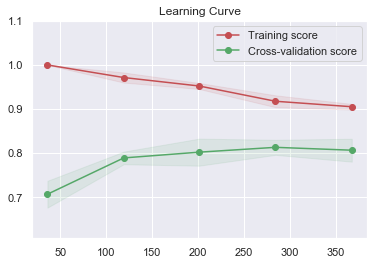

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)


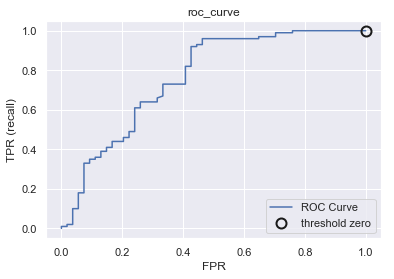

In [24]:
from xgboost.sklearn import XGBClassifier

xgbr = XGBClassifier(n_estimators=100, silent=False)
xgbr.fit(X_trainmodel ,y_trainmodel.values.ravel())

warnings.filterwarnings("ignore", category=DeprecationWarning) 

best_model ,result = test_classifier(xgbr,X_trainmodel,y_trainmodel,kfold)
print(best_model)
plot_roc(X_val,y_val,best_model)

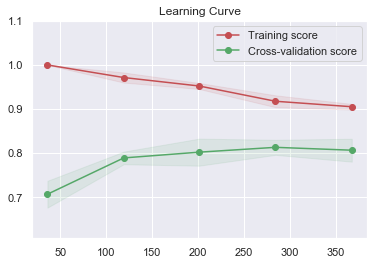

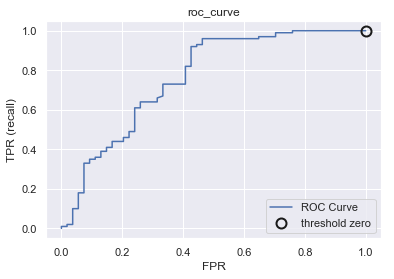

Classification report
              precision    recall  f1-score   support

         0.0       0.85      0.54      0.66        54
         1.0       0.79      0.95      0.86       100

   micro avg       0.81      0.81      0.81       154
   macro avg       0.82      0.74      0.76       154
weighted avg       0.81      0.81      0.79       154

Confusion matrix
[[29 25]
 [ 5 95]]


In [25]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
evaluvate_model(xgbr,X_trainmodel, y_trainmodel,X_val,y_val)

In [26]:
def calc_accuracy(predictions, y_test):
    labels = y_test.get_label()
    return 'accuracy_score', (1 - sum(labels != predictions)/len(labels))

In [27]:
import xgboost as xgb

In [28]:
params = {"objective": "multi:softmax",
          'num_class': 2,
          "booster" : "gbtree",
          'learning_rate': 0.1,
          "max_depth": 3,
          "subsample": 0.7,
          'colsample_bylevel': 1,
          'colsample_bytree': 1,
          'gamma': 0,
          'min_child_weight': 1,
          "silent": 1,
          }

num_boost_round =60

In [29]:
print("Train a XGBoost model")
dtrain = xgb.DMatrix(X_trainmodel, y_trainmodel)
dvalid = xgb.DMatrix(X_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, watchlist,
                feval=calc_accuracy, maximize=True, early_stopping_rounds=50, verbose_eval=True)

Train a XGBoost model
[0]	train-merror:0.16087	eval-merror:0.214286	train-accuracy_score:0.83913	eval-accuracy_score:0.785714
Multiple eval metrics have been passed: 'eval-accuracy_score' will be used for early stopping.

Will train until eval-accuracy_score hasn't improved in 50 rounds.
[1]	train-merror:0.165217	eval-merror:0.214286	train-accuracy_score:0.834783	eval-accuracy_score:0.785714
[2]	train-merror:0.16087	eval-merror:0.214286	train-accuracy_score:0.83913	eval-accuracy_score:0.785714
[3]	train-merror:0.158696	eval-merror:0.214286	train-accuracy_score:0.841304	eval-accuracy_score:0.785714
[4]	train-merror:0.156522	eval-merror:0.207792	train-accuracy_score:0.843478	eval-accuracy_score:0.792208
[5]	train-merror:0.156522	eval-merror:0.207792	train-accuracy_score:0.843478	eval-accuracy_score:0.792208
[6]	train-merror:0.156522	eval-merror:0.207792	train-accuracy_score:0.843478	eval-accuracy_score:0.792208
[7]	train-merror:0.156522	eval-merror:0.207792	train-accuracy_score:0.843478	

Text(0.5,1,'XGBoost Feature Importance')

Text(0.5,0,'relative importance')

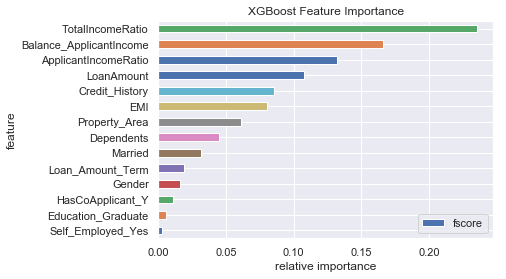

In [30]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

import operator
create_feature_map(X_trainmodel)

importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df_importances = pd.DataFrame(importance, columns=['feature', 'fscore'])
df_importances['fscore'] = df_importances['fscore'] / df_importances['fscore'].sum()

df_importances.plot(kind='barh', x='feature', y='fscore')
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [31]:
test_y  =gbm.predict(xgb.DMatrix(test_X))

In [32]:
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d_%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="LoanAV_Pred_"+timestamp+".csv"

In [33]:
submission.to_csv(filename,index=False)